# Data Preparation Section #

### Collecting packages

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType, TimestampType, BooleanType
from pyspark.sql.functions import col, year
import seaborn as sns

### Starting Spark Context and Spark Session

In [2]:
# Configure SparkUI
conf = SparkConf().set('spark.ui.port', '4050')

# Create a URL through you can access the Spark UI
get_ipython().system_raw('./ngrok http 4050 &')

# Access the URL
!curl -s http://localhost:4040/api/tunnels 

# Creating a context. Access SparkUI now in localhost:4050
sc = SparkContext(conf=conf)

In [3]:
# Starting Spark Session
spark = (
    SparkSession.builder                  
      .config('spark.ui.port', '4050')
      .appName("music_spark_session")
      .getOrCreate()
)

### Defining schema and collecting data

In [4]:
path_data = "top_10000_1960-now.csv"

schema_music = StructType([
    StructField('Track URI', StringType()),
    StructField('Track Name', StringType()),
    StructField('Artist URI', StringType()),
    StructField('Artist Name', StringType()),
    StructField('Album URI', StringType()),
    StructField('Album Name', StringType()),
    StructField('Album Artist URI', StringType()),
    StructField('Album Artist Name', StringType()),
    StructField('Album Release Date', TimestampType()),
    StructField('Album Image URL', StringType()),
    StructField('Disc Number', IntegerType()),
    StructField('Track Number', IntegerType()),
    StructField('Track Duration', IntegerType()),
    StructField('Track Preview URL', StringType()),
    StructField('Explicit', BooleanType()),
    StructField('Popularity', IntegerType()),
    StructField('ISRC', StringType()),
    StructField('Added By', StringType()),
    StructField('Added At', StringType()),
    StructField('Artist Genres', StringType()),
    StructField('Danceability', DoubleType()),
    StructField('Energy', DoubleType()),
    StructField('Key', IntegerType()),
    StructField('Loudness', DoubleType()),
    StructField('Mode', IntegerType()),
    StructField('Speechiness', DoubleType()),
    StructField('Acousticness', DoubleType()),
    StructField('Instrumentalness', DoubleType()),
    StructField('Liveness', DoubleType()),
    StructField('Valence', DoubleType()),
    StructField('Tempo', DoubleType()),
    StructField('Time Signature', IntegerType()),
    StructField('Album Genres', StringType()),
    StructField('Label', StringType()),
    StructField('Copyrights', StringType())
])

df = spark.read.csv(
    path_data,
    header=True,
    sep=',',
    schema=schema_music,
    timestampFormat="yyyy-MM-dd"
)

# Dropping columns not going to be used for model
df = df.drop(
    'Track Name',
    'Artist Name',
    'Mode',
    'Explicit',
    'Track URI', 
    'Artist URI',
    'Artist Genres',
    'Album URI',
    'Album Name',
    'Disc Number',
    'Track Number',
    'Album Artist URI',
    'Album Artist Name',
    'Album Image URL',
    'Speechiness',
    'Time Signature',
    'Track Preview URL',
    'ISRC',
    'Added By',
    'Added At',
    'Album Genres',
    'Label',
    'Copyrights',
)

In [5]:
df.printSchema()

root
 |-- Album Release Date: timestamp (nullable = true)
 |-- Track Duration: integer (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- Danceability: double (nullable = true)
 |-- Energy: double (nullable = true)
 |-- Key: integer (nullable = true)
 |-- Loudness: double (nullable = true)
 |-- Acousticness: double (nullable = true)
 |-- Instrumentalness: double (nullable = true)
 |-- Liveness: double (nullable = true)
 |-- Valence: double (nullable = true)
 |-- Tempo: double (nullable = true)



### Data cleaning

1. Changing 'Album Release Date' column to 'Year'.

In [6]:
df = df.withColumn(
    'Year', year(col('Album Release Date'))
).drop(col('Album Release Date'))

2. Removing invalid values for 'Energy', 'Valence', 'Track duration', 'Tempo' and 'Loudness' (according to the Data Understanding Section)

In [7]:
df = df.filter(
    (col('Energy') <= 1) &
    (col('Valence') <= 1) &
    (col('Track duration') >= 10000.0) &
    (col('Tempo') >= 20.0) &
    (col('Loudness') <= 0.0)
)

In [8]:
df.printSchema()

root
 |-- Track Duration: integer (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- Danceability: double (nullable = true)
 |-- Energy: double (nullable = true)
 |-- Key: integer (nullable = true)
 |-- Loudness: double (nullable = true)
 |-- Acousticness: double (nullable = true)
 |-- Instrumentalness: double (nullable = true)
 |-- Liveness: double (nullable = true)
 |-- Valence: double (nullable = true)
 |-- Tempo: double (nullable = true)
 |-- Year: integer (nullable = true)



In [9]:
df.show()

+--------------+----------+------------+------+---+--------+------------+----------------+--------+-------+-------+----+
|Track Duration|Popularity|Danceability|Energy|Key|Loudness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|Year|
+--------------+----------+------------+------+---+--------+------------+----------------+--------+-------+-------+----+
|        216270|         0|       0.617| 0.872|  8| -12.305|      0.0158|           0.112|   0.408|  0.504|111.458|1992|
|        237120|        64|       0.825| 0.743|  2|  -5.995|      0.0142|         2.12E-5|   0.237|    0.8|127.045|2009|
|        312533|        56|       0.677| 0.665|  7|  -5.171|        0.56|         1.01E-6|   0.338|  0.706| 74.981|1999|
|        233400|        42|       0.683| 0.728|  9|   -8.92|       0.568|         5.08E-5|  0.0384|  0.833| 75.311|2014|
|        448720|         0|       0.319| 0.627|  0|  -9.611|       0.675|         7.29E-5|   0.289|  0.497| 85.818|1969|
|        193346|        79|     

In [10]:
df.describe('Track Duration', 'Popularity', 'Danceability', 'Energy', 'Key', 'Loudness').show()

+-------+------------------+------------------+-------------------+-------------------+------------------+------------------+
|summary|    Track Duration|        Popularity|       Danceability|             Energy|               Key|          Loudness|
+-------+------------------+------------------+-------------------+-------------------+------------------+------------------+
|  count|              9988|              9988|               9988|               9988|              9988|              9988|
|   mean|224861.99559471366|37.649679615538645| 0.6079929315178216| 0.6832941850520632| 5.168001601922307|-7.269486183420098|
| stddev| 54044.31480213196| 29.45845657464704|0.14572107317273333|0.19109722281133817|3.5779395576391413| 3.279945427277261|
|    min|             91226|                 0|             0.0994|            2.03E-5|                 0|           -29.368|
|    max|           1561133|                98|              0.988|              0.997|                11|            

In [11]:
df.describe('Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Year').show()

+-------+-------------------+--------------------+-------------------+------------------+------------------+------------------+
|summary|       Acousticness|    Instrumentalness|           Liveness|           Valence|             Tempo|              Year|
+-------+-------------------+--------------------+-------------------+------------------+------------------+------------------+
|  count|               9988|                9988|               9988|              9988|              9988|              9988|
|   mean|0.20843371658189822|0.029307049545454475| 0.1857686724068884|  0.58545702843412|121.50083990788956| 2001.824088906688|
| stddev|0.24870662523952852| 0.12353925224905446|0.14921261105901332|0.2391001690584038| 26.22200118439957|15.210179053245437|
|    min|            2.72E-6|                 0.0|              0.012|            0.0334|            34.999|              1956|
|    max|              0.991|               0.985|              0.989|             0.995|           217.

In [12]:
df = df.dropna()

There were no longer null values after the cleaning, as the dataset still has 9988 rows.

In [13]:
df.count()

9988

In [14]:
df.createOrReplaceTempView('clean_music_df')

sqlStatement_numeric = """
      select `Track Duration`,
             Danceability,
             Year,
             Energy,
             Loudness,
             Valence,
             Tempo
        from clean_music_df
    """

pairplot = spark.sql(sqlStatement_numeric).toPandas();

### Pairplot after cleaning

C:\Users\Matheus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


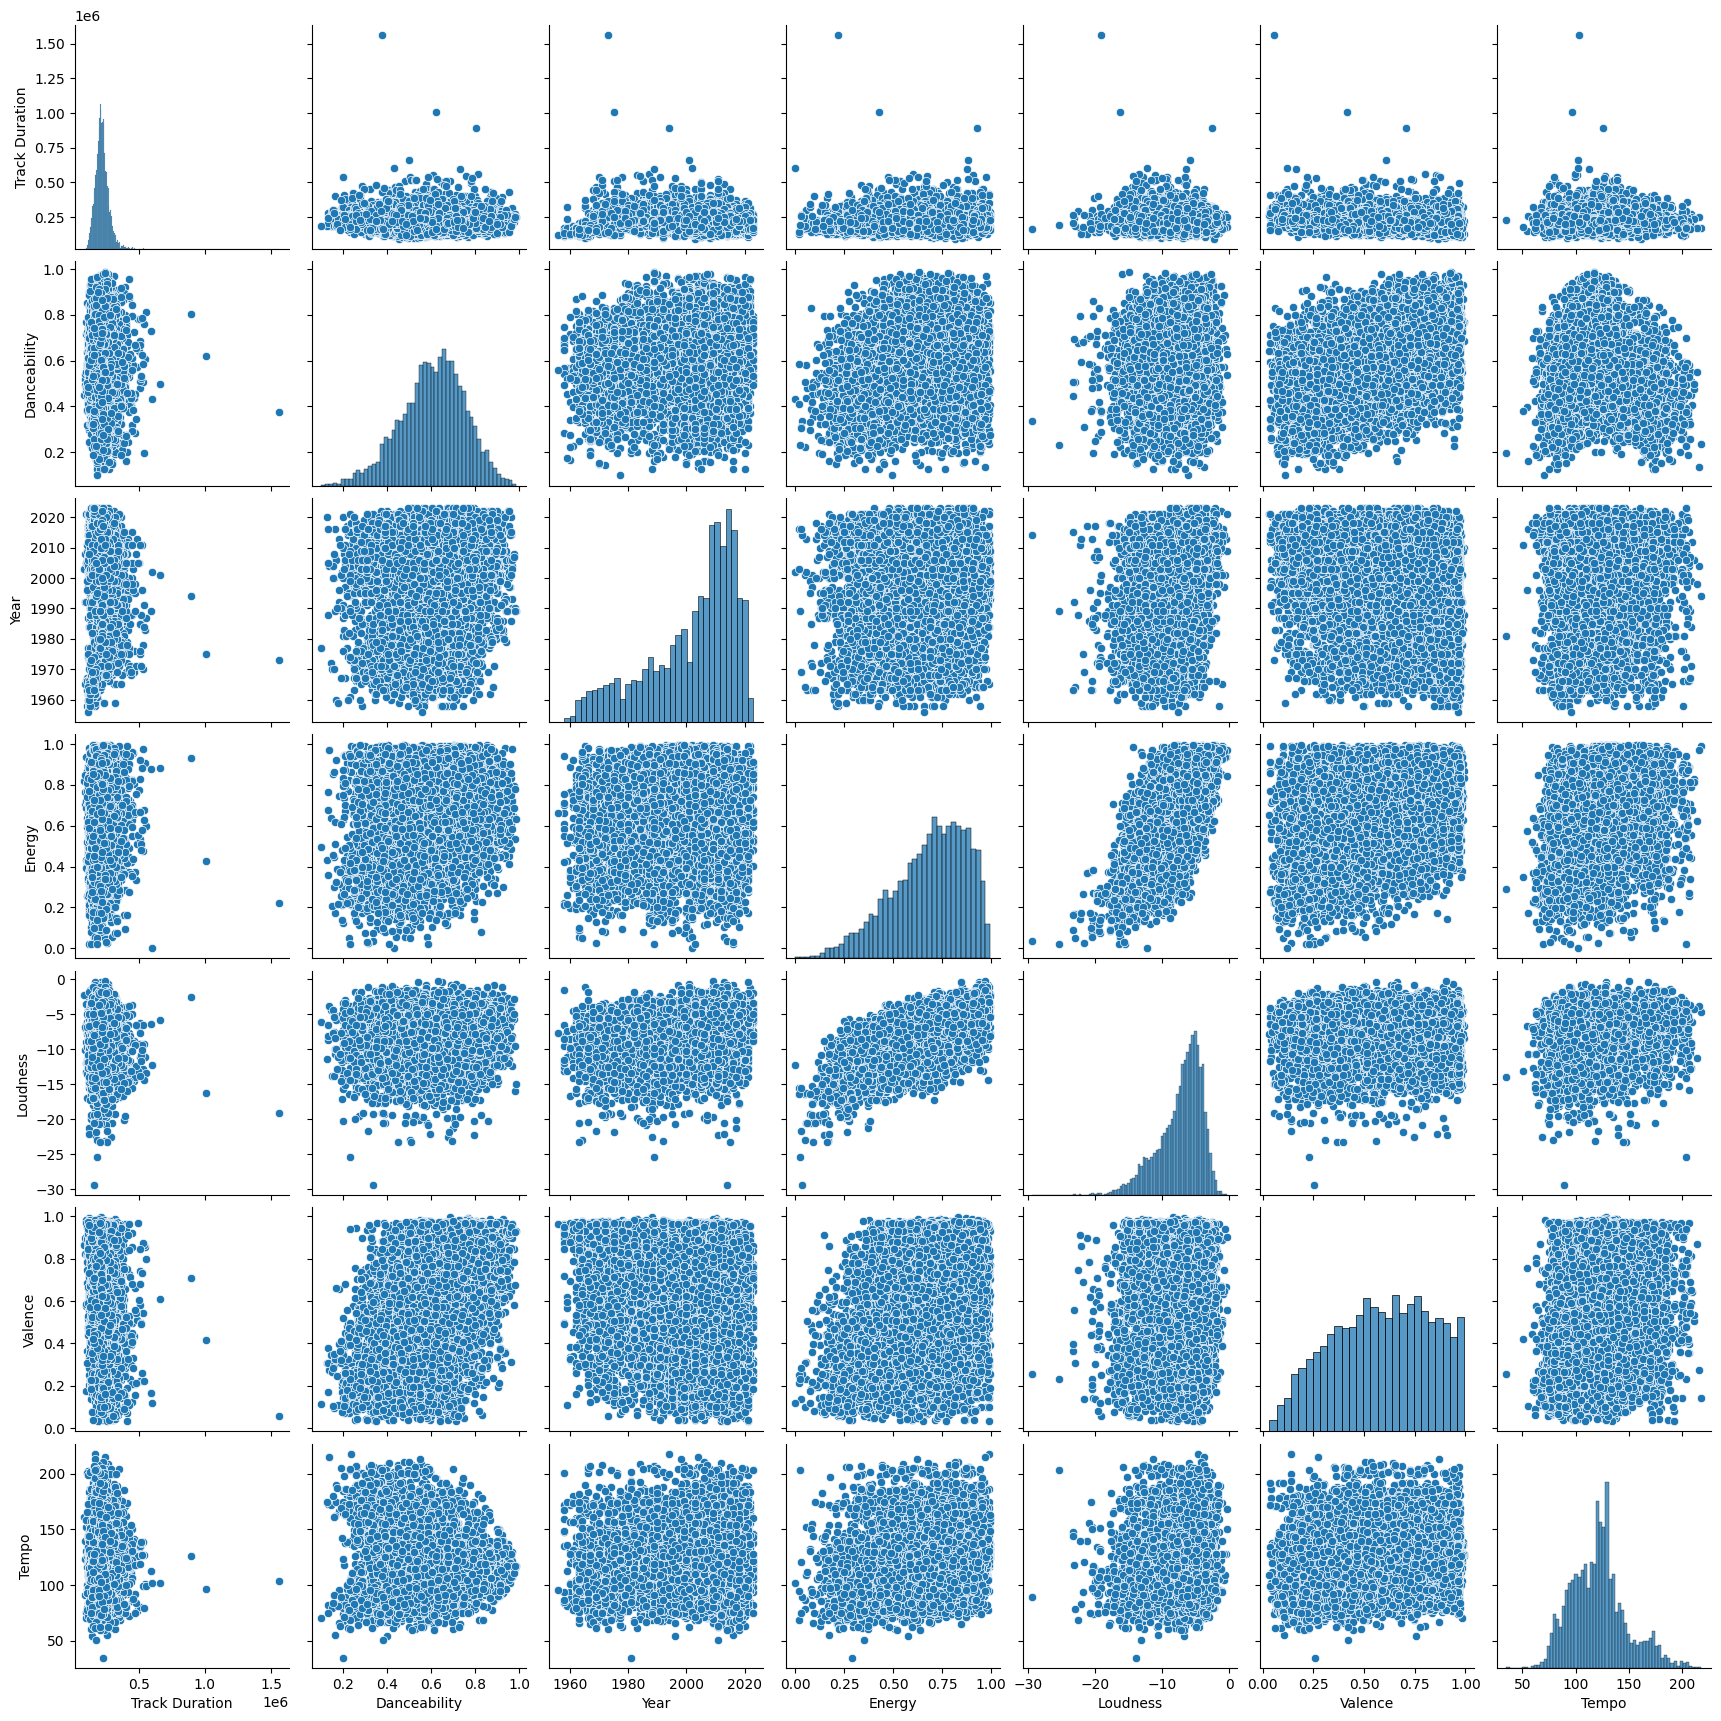

In [15]:
sns.pairplot(pairplot)

### Export clean data as csv file for modeling 

In [16]:
df.rdd.getNumPartitions()

2

In [17]:
!wmic cpu list /format:list





AddressWidth=64

Architecture=9

Availability=3

Caption=Intel64 Family 6 Model 140 Stepping 1

ConfigManagerErrorCode=

ConfigManagerUserConfig=

CpuStatus=1

CreationClassName=Win32_Processor

CurrentClockSpeed=2419

CurrentVoltage=10

DataWidth=64

Description=Intel64 Family 6 Model 140 Stepping 1

DeviceID=CPU0

ErrorCleared=

ErrorDescription=

ExtClock=100

Family=205

InstallDate=

L2CacheSize=5120

L2CacheSpeed=

LastErrorCode=

Level=6

LoadPercentage=12

Manufacturer=GenuineIntel

MaxClockSpeed=2419

Name=11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz

OtherFamilyDescription=

PNPDeviceID=

PowerManagementCapabilities=

PowerManagementSupported=FALSE

ProcessorId=BFEBFBFF000806C1

ProcessorType=3

Revision=

Role=CPU

SocketDesignation=U3E1

Status=OK

StatusInfo=3

Stepping=

SystemCreationClassName=Win32_ComputerSystem

SystemName=MTHS

UniqueId=

UpgradeMethod=1

Version=

VoltageCaps=









In [20]:
# Save parquet partitions by year in parquet for future studies

# Use this code case have multiple columns with whitespace character
def replace_whitesp(df):
    for column in df.columns:
        df = df.withColumnRenamed(str(column), str(column).replace('', '_'))

def StandardizeNames(df):
    l = df.columns
    cols = [c.replace(' ','_').
              replace('[.]','_').
              replace('.','_').
              replace('[[:punct:]]','_').
              lower() for c in l]
    return df.toDF(*cols)

df = df.withColumnRenamed('Track Duration', 'Track_duration') 


df.write.mode('overwrite').partitionBy('Year').parquet('years/parquet/base')

# OBS.: In windows this last line can show error. To solve this, 
# add HADOOP_HOME as SYSTEM env variable with files available on https://github.com/cdarlint/winutils
# with the local on path: %HADOOP_HOME%\bin\winutils.exe

In [21]:
df.toPandas().to_csv('clean_data_music.csv')

In [22]:
spark.stop()